# 準備

## Googleドライブのマウント

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## sys.pathの設定

以下では，Googleドライブのマイドライブ直下にDNN_codeフォルダを置くことを仮定しています．必要に応じて，パスを変更してください．

In [6]:
import sys
sys.path.append('/content/drive/My Drive/DNN_code')

# simple RNN
### バイナリ加算

中間層の活性化関数がsigmoidの時、学習は比較的上手くいく。XavierやHeの初期値を使用する事によって収束により時間がかかるように思われる。


iters:0
Loss:0.9429043122747464
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 0 0 0 1]
24 + 57 = 0
------------
iters:100
Loss:1.0547342079647437
Pred:[0 0 1 1 0 0 1 0]
True:[1 0 0 0 0 1 1 1]
77 + 58 = 50
------------
iters:200
Loss:0.9232689074956549
Pred:[1 0 0 1 1 0 1 1]
True:[1 0 0 0 1 1 1 1]
116 + 27 = 155
------------
iters:300
Loss:1.0478613808689874
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 0 0 0 0 1]
61 + 68 = 255
------------
iters:400
Loss:1.0290011776281351
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 1 1 1 1 0]
123 + 35 = 0
------------
iters:500
Loss:0.9550435162731711
Pred:[0 0 0 0 0 1 1 1]
True:[0 0 0 0 1 1 1 1]
14 + 1 = 7
------------
iters:600
Loss:0.9692198407121941
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 1 0 1 1 0 1]
32 + 13 = 255
------------
iters:700
Loss:1.1067852419472106
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 1 1 1 1]
60 + 115 = 0
------------
iters:800
Loss:1.0298509401071865
Pred:[1 1 1 1 1 1 1 1]
True:[1 1 1 1 0 0 0 0]
115 + 125 = 255
------------
iters:900
Loss:0.9692590446114921
Pred:[1 1 

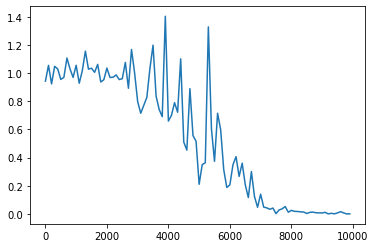

In [39]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
  sinh = (np.exp(x) - np.exp(-x)) / 2
  cosh = (np.exp(x) + np.exp(-x)) / 2
  return (cosh**2 - sinh**2) / cosh**2

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16 #16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1 #0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])

        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))


        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        
        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## [try] weight_init_stdやlearning_rate, hidden_layer_sizeを変更してみよう


## [try] 重みの初期化方法を変更してみよう
Xavier, He

## [try] 中間層の活性化関数を変更してみよう
ReLU(勾配爆発を確認しよう)<br>
tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 中間層の活性化関数をReLUに変更する事によって勾配爆発を確認する。

中間層の活性化関数をReLUに変更すると勾配爆発によって学習ができなくなる。

iters:0
Loss:813.5084572821481
Pred:[ 0  0  0 26 28 16  0  1]
True:[0 0 1 0 1 1 1 1]
6 + 41 = 705
------------
iters:100
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 0 1 0]
59 + 31 = 0
------------
iters:200
Loss:2.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 1 0 0 1 1]
1 + 114 = 0
------------
iters:300
Loss:1.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 1 1 0 1 0]
22 + 4 = 0
------------
iters:400
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 1 1 0 1 0]
74 + 16 = 0
------------
iters:500
Loss:2.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 1 1 1]
28 + 75 = 0
------------
iters:600
Loss:1.5
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 1 0 0]
52 + 24 = 0
------------
iters:700
Loss:2.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 0 1 0 1]
22 + 31 = 0
------------
iters:800
Loss:1.5
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 1 0 1 0 0 0]
120 + 48 = 0
------------
iters:900
Loss:1.0
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 1 0 0 0]
19 + 53 = 0
------------
iters:1000
Loss:2.5
Pred:[0 0 0 0 0 0 0 0]
True:[1 1 0 1 1 0 1 0]
127 + 91 = 0


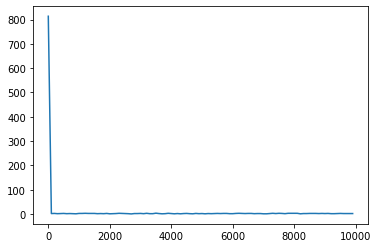

In [40]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
  sinh = (np.exp(x) - np.exp(-x)) / 2
  cosh = (np.exp(x) + np.exp(-x)) / 2
  return (cosh**2 - sinh**2) / cosh**2

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / (np.sqrt(input_layer_size))
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / (np.sqrt(hidden_layer_size))
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / (np.sqrt(hidden_layer_size))

# He
# W_in = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
# W_out = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)
# W = np.random.randn(hidden_layer_size, hidden_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        # z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = functions.relu(u[:,t+1])

        # y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        y[:,t] = functions.relu(np.dot(z[:,t+1].reshape(1, -1), W_out))

        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        # delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_relu(y[:,t])    

        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_relu(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

## tanh(numpyにtanhが用意されている。導関数をd_tanhとして作成しよう)

中間層の活性化関数をtanhに変更し（かつHeの初期値を使用すると）かなり学習がスムーズに行われる。

iters:0
Loss:1.5255512270821048
Pred:[1 1 1 1 1 1 1 1]
True:[0 0 0 1 1 0 1 0]
13 + 13 = 255
------------
iters:100
Loss:0.884806362486125
Pred:[1 0 1 1 0 0 1 0]
True:[1 0 1 0 1 0 1 0]
73 + 97 = 178
------------
iters:200
Loss:1.1546995189762557
Pred:[1 1 1 1 1 1 1 0]
True:[0 1 0 1 0 1 0 0]
18 + 66 = 254
------------
iters:300
Loss:1.2666783628823797
Pred:[0 0 1 1 0 1 0 1]
True:[0 1 0 1 1 0 1 1]
57 + 34 = 53
------------
iters:400
Loss:0.6895750947315344
Pred:[255   1   1   1   1   1   1   0]
True:[0 1 1 1 1 0 0 0]
14 + 106 = 32766
------------
iters:500
Loss:1.0064350476803812
Pred:[0 1 1 0 1 1 0 1]
True:[0 1 1 1 0 0 0 1]
59 + 54 = 109
------------
iters:600
Loss:0.22524072358061936
Pred:[1 0 1 0 0 0 0 1]
True:[1 0 1 0 0 0 0 1]
88 + 73 = 161
------------
iters:700
Loss:0.6085339327448556
Pred:[0 1 1 0 0 0 0 0]
True:[0 1 0 0 0 0 0 0]
27 + 37 = 96
------------
iters:800
Loss:0.049007056243507374
Pred:[0 1 1 0 1 1 1 0]
True:[0 1 1 0 1 1 1 0]
41 + 69 = 110
------------
iters:900
Loss:0.431

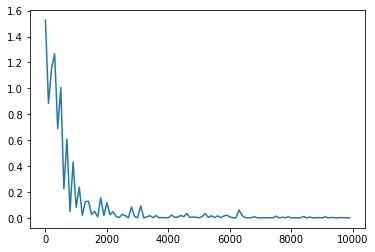

In [33]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

def d_tanh(x):
  sinh = (np.exp(x) - np.exp(-x)) / 2
  cosh = (np.exp(x) + np.exp(-x)) / 2
  return (cosh**2 - sinh**2) / cosh**2

# データを用意
# 2進数の桁数
binary_dim = 8
# 最大値 + 1
largest_number = pow(2, binary_dim)
# largest_numberまで2進数を用意
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1

weight_init_std = 1
learning_rate = 0.1

iters_num = 10000
plot_interval = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# Xavier


# He
W_in = np.random.randn(input_layer_size, hidden_layer_size) / np.sqrt(input_layer_size) * np.sqrt(2)
W_out = np.random.randn(hidden_layer_size, output_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)
W = np.random.randn(hidden_layer_size, hidden_layer_size) / np.sqrt(hidden_layer_size) * np.sqrt(2)


# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

for i in range(iters_num):
    
    # A, B初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int] # binary encoding
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int] # binary encoding
    
    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]
    
    # 出力バイナリ
    out_bin = np.zeros_like(d_bin)
    
    # 時系列全体の誤差
    all_loss = 0    
    
    # 時系列ループ
    for t in range(binary_dim):
        # 入力値
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        # 時刻tにおける正解データ
        dd = np.array([d_bin[binary_dim - t - 1]])
        
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        # z[:,t+1] = functions.sigmoid(u[:,t+1])
        z[:,t+1] = np.tanh(u[:,t+1])

        # y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        y[:,t] = np.tanh(np.dot(z[:,t+1].reshape(1, -1), W_out))

        #誤差
        loss = functions.mean_squared_error(dd, y[:,t])
        
        # delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * d_tanh(y[:,t])    

        all_loss += loss

        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        

        # delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * d_tanh(u[:,t+1])

        # 勾配更新
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    

    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        print("iters:" + str(i))
        print("Loss:" + str(all_loss))
        print("Pred:" + str(out_bin))
        print("True:" + str(d_bin))
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)
        print(str(a_int) + " + " + str(b_int) + " = " + str(out_int))
        print("------------")

lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()